In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import csv
import glob

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults

import pickle
#from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [129]:
import time
import numpy
import pandas
import math
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
# loading csv file
def get_csv_pd(path):
    #spy_pd=pd.read_csv('C:\\Users\Michal\Dropbox\IB_data\SPY.csv',sep=' ',names=['askPrice','askSize','bidPrice','bidSize'],index_col=0,parse_dates=True)
    #spy_pd=pd.read_csv(path+'\SPY.csv',sep=',',names=['askPrice','askSize','bidPrice','bidSize'],index_col=0,parse_dates=True)
    spy_pd=pd.read_csv(path,sep=',',dtype={'askPrice':np.float32,'askSize':np.float32,
                                           'bidPrice':np.float32,'bidSize':np.float32},index_col=0,parse_dates=True)
    #spy_pd = pd.read_csv(path, usecols=['askPrice','askSize','bidPrice','bidSize'], engine='python', skipfooter=3)
    return spy_pd
'''
def get_csv_pd_notime(path):
    #spy_pd=pd.read_csv('C:\\Users\Michal\Dropbox\IB_data\SPY.csv',sep=' ',names=['askPrice','askSize','bidPrice','bidSize'],index_col=0,parse_dates=True)
    #spy_pd=pd.read_csv(path+'\SPY.csv',sep=',',names=['askPrice','askSize','bidPrice','bidSize'],index_col=0,parse_dates=True)
    spy_pd = pd.read_csv(path, usecols=['askPrice','askSize','bidPrice','bidSize'], engine='python', skipfooter=3)
    return spy_pd
'''

def preprocessing(df):
    df.bidPrice=df.loc[:,'bidPrice'].replace(to_replace=0, method='ffill')
    df.bidSize=df.loc[:,'bidSize'].replace(to_replace=0, method='ffill')
    df.askPrice=df.loc[:,'askPrice'].replace(to_replace=0, method='ffill')
    df.askSize=df.loc[:,'askSize'].replace(to_replace=0, method='ffill')
    df=df.dropna()
    # to exclude 0
    df=df[df['bidPrice']>df.bidPrice.mean()-df.bidPrice.std()]
    df=df[df['askPrice']>df.askPrice.mean()-df.askPrice.std()]
    df['mid']=(df.askPrice+df.bidPrice)/2
    df['vwap']=((df.loc[:,'bidPrice']*df.loc[:,'bidSize'])+(df.loc[:,'askPrice']*df.loc[:,'askSize']))/(df.loc[:,'bidSize']+df.loc[:,'askSize'])
    df['spread']=df.vwap-(df.askPrice+df.bidPrice)/2
    df['v']=(df.askPrice+df.bidPrice)/2-((df.askPrice+df.bidPrice)/2).shift(60)
    df['return']=(df.askPrice/df.bidPrice.shift(1))-1
    df['sigma']=df.spread.rolling(60).std()
    return df

'''
def normalise(df,window_length=60):
    dfn=(df-df.rolling(window_length).min())/(df.rolling(window_length).max()-df.rolling(window_length).min())
    return dfn

def de_normalise(data,df,window_length=60):
    dn=(df*(data.rolling(window_length).max()-data.rolling(window_length).min()))+data.rolling(window_length).min()
    return dn

def normalise_z(df,window_length=12):
    dfn=(df-df.rolling(window_length).mean())/(df.rolling(window_length).std())
    return dfn

'''
def normalise(df,window_length=60):
    data=df[['askPrice','askSize','bidPrice','bidSize','vwap','spread','v','return','sigma']]
    dfn=data/data.shift(60)
    return dfn

def de_normalise(dfn,window_length=60):
    data=df[['askPrice','askSize','bidPrice','bidSize','vwap','spread','v','return','sigma']]
    data=dfn*data.shift(60)
    return data

#https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
ARIMA.__getnewargs__ = __getnewargs__


def arima_processing(df):
    #data=df[['vwap','mid']]
    df=df.dropna()
    df['Lvwap']=np.log(df.vwap)
    df['Lmid']=np.log(df.mid)
    df['LDvwap']=df.Lvwap-df.Lvwap.shift(60)
    df['LDmid']=df.Lmid-df.Lmid.shift(60)
    df=df.dropna()
    return df  

def ARIMA_saving(data):
    data=data.dropna()
    data1=data.LDvwap
    data2=data.LDmid
    
    model_vwap = ARIMA(data1,order=(2,1,2))  # tested from ARIMA.ipynb
    #predictions = model.fit(disp=0).predict()
    predictions_vwap =model_vwap.fit(disp=0).fittedvalues
    # save model
    model_vwap.fit().save('vwap_arima.pkl')
    vwap_arima=np.exp(predictions_vwap+data.Lvwap.shift(60))
    
    model_mid = ARIMA(data2,order=(2,1,2))  # tested from ARIMA.ipynb
    #predictions = model.fit(disp=0).predict()
    predictions_mid =model_mid.fit(disp=0).fittedvalues
    # save model
    model_mid.fit().save('mid_arima.pkl')        

In [3]:
filename = '/home/octo/Dropbox'+ '/SPY7Dec.csv'

##### saving Arima model

In [8]:
data=get_csv_pd(filename)
data=preprocessing(data)
data=data.dropna()
data=arima_processing(data)
data=data.dropna()
ARIMA_saving(data)

/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [9]:
data.head()

,askPrice,askSize,bidPrice,bidSize,mid,vwap,spread,v,return,sigma,Lvwap,Lmid,LDvwap,LDmid
2017-12-07 20:13:18.071447,263.269989,1.0,263.260010,222.0,263.265015,263.260040,-0.004974,0.000000,0.000038,0.004030,5.573142,5.573161,-0.000037,0.000000
2017-12-07 20:13:18.366477,263.269989,1.0,263.269989,222.0,263.269989,263.269989,0.000000,0.004974,0.000038,0.004022,5.573180,5.573180,0.000001,0.000019
2017-12-07 20:13:18.654352,263.269989,1.0,263.269989,3.0,263.269989,263.269989,0.000000,0.004974,0.000000,0.004013,5.573180,5.573180,0.000001,0.000019
2017-12-07 20:13:18.951643,263.279999,1.0,263.269989,3.0,263.274994,263.272491,-0.002502,0.009979,0.000038,0.004038,5.573190,5.573199,0.000012,0.000038
2017-12-07 20:13:19.246497,263.279999,321.0,263.269989,3.0,263.274994,263.279938,0.004944,0.009979,0.000038,0.004045,5.573218,5.573199,0.000040,0.000038


##### No need to save KM model

##### Linear Regression, sklearn, svm:SVR,linear_model

In [10]:
data=get_csv_pd(filename)
data=preprocessing(data)
#data=normalise(data)
data=data.dropna()

In [11]:
data.tail()

,askPrice,askSize,bidPrice,bidSize,mid,vwap,spread,v,return,sigma
2017-12-08 03:00:32.244925,263.839996,1.0,263.829987,576.0,263.834991,263.830017,-0.004974,0.019989,0.000038,0.003702
2017-12-08 03:00:34.284669,263.839996,1.0,263.829987,563.0,263.834991,263.830017,-0.004974,0.014984,0.000038,0.003723
2017-12-08 03:00:35.874931,263.839996,1.0,263.839996,563.0,263.839996,263.839996,0.000000,0.019989,0.000038,0.003723
2017-12-08 03:00:37.499670,263.839996,1.0,263.839996,17.0,263.839996,263.839966,-0.000031,0.014984,0.000000,0.003723
2017-12-08 03:00:39.356631,263.850006,1.0,263.839996,17.0,263.845001,263.840546,-0.004456,0.019989,0.000038,0.003652


In [12]:
df=data
X=df[['vwap','v','return','sigma']]
y=df.mid

In [13]:
regr = linear_model.LinearRegression()
regr_model=regr.fit(X,y)
# save the model to disk
filename_rgr = 'rgr.sav'
pickle.dump(regr_model, open(filename_rgr, 'wb'))

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.9) #kernel='linear' #kernel='poly'
svr_model = svr_rbf.fit(X, y)
# save the model to disk
filename_svr = 'svr.sav'
pickle.dump(svr_model, open(filename_svr, 'wb'))

##### Classification is based on the previous predictions, so need to build the dataframe df_ml

In [14]:
###Model is already saved from "/Dropbox/DataScience/ARIMA_model_saving.ipynb". Here loaded and added to "df_ml"
def ARIMA_(data):
    ### load model
    data=data.dropna()
    predictions_mid=ARIMA_mid(data.LDmid)
    predictions_vwap=ARIMA_vwap(data.LDvwap) 
    vwap_arima=np.exp(predictions_vwap+data.Lvwap.shift(60))
    mid_arima=np.exp(predictions_mid+data.Lmid.shift(60))
    df_ml['arima']=data.mid+vwap_arima-mid_arima
    
def ARIMA_mid(data):
    ### load model
    mid_arima_loaded = ARIMAResults.load('mid_arima.pkl')
    predictions_mid = mid_arima_loaded.predict()
    return predictions_mid

def ARIMA_vwap(data):
    ### load model
    vwap_arima_loaded = ARIMAResults.load('vwap_arima.pkl')
    predictions_vwap = vwap_arima_loaded.predict()
    return predictions_vwap

#### KALMAN moving average

##KF moving average
#https://github.com/pykalman/pykalman

# Import a Kalman filter and other useful libraries
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import poly1d

def kalman_ma(data):
    #x=data.mid
    x=data.mid
    # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 248,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

    # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    df_ml['km']=state_means

### Linear Regression, sklearn, svm:SVR,linear_model
import pickle
#from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


## loading model saved from /Dropbox/DataScience/REG_model_saving.ipynb
filename_rgr = 'rgr.sav'
filename_svr = 'svr.sav'
# load the model from disk
loaded_rgr_model = pickle.load(open(filename_rgr, 'rb'))
loaded_svr_model = pickle.load(open(filename_svr, 'rb'))

def strat_lr(data):
    #no normalization
    
    data=data.dropna()
    X=data[['vwap','v','return','sigma']]
    #y=df[['mid']]
    predict_regr=loaded_rgr_model.predict(X)
    predict_svr=loaded_svr_model.predict(X)
    
    df_ml['REG']=predict_regr
    df_ml['SVR']=predict_svr
    
    ## strat_lr(data,dfn) and below needed for normalized data
    #df_ml['predict_regr']=predict_regr
    #df_ml['predict_svr']=predict_svr
    #df_ml['REG']=de_normalise(data.mid,df.predict_regr)
    #df_ml['SVR']=de_normalise(data.mid,df.predict_svr)

##### creating the df_ml dataset

In [69]:
df_ml=pd.DataFrame()
data=get_csv_pd(filename)
data=preprocessing(data)
data=data.dropna()
df_arima=arima_processing(data)
df_ml['mid']=data.mid
df_ml['vwap']=data.vwap
ARIMA_(df_arima)
kalman_ma(data)
strat_lr(data)

In [100]:
df_ml.dropna().head()

,mid,vwap,arima,km,REG,SVR,UD
2017-12-07 20:13:37.388207,263.304993,263.307831,263.300703,263.297371,263.307217,263.377362,0
2017-12-07 20:13:37.859897,263.309998,263.309967,263.310746,263.298572,263.309350,263.378741,0
2017-12-07 20:13:38.330945,263.309998,263.309967,263.308663,263.299659,263.308788,263.378741,0
2017-12-07 20:13:38.802144,263.315002,263.319916,263.310354,263.301118,263.319292,263.385214,0
2017-12-07 20:13:39.252239,263.315002,263.319946,263.320369,263.302439,263.319322,263.385234,0


In [71]:
len(df_ml)

22308

### Classification

In [72]:
df_ml=df_ml.dropna()
data_cl=data.tail(len(df_ml))
data_cl['U']=np.where(df_ml.mid>df_ml.km,1,0)
data_cl['D']=np.where(df_ml.mid<df_ml.km,-1,0)
data_cl=data_cl.dropna()

/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [90]:
data_cl.head()

,askPrice,askSize,bidPrice,bidSize,mid,vwap,spread,v,return,sigma,U,D
2017-12-07 20:13:37.388207,263.309998,126.0,263.299988,35.0,263.304993,263.307831,0.002838,0.039978,0.000038,0.003502,1,0
2017-12-07 20:13:37.859897,263.309998,126.0,263.309998,35.0,263.309998,263.309967,-0.000031,0.040009,0.000038,0.003503,1,0
2017-12-07 20:13:38.330945,263.309998,126.0,263.309998,1.0,263.309998,263.309967,-0.000031,0.040009,0.000000,0.003503,1,0
2017-12-07 20:13:38.802144,263.320007,126.0,263.309998,1.0,263.315002,263.319916,0.004913,0.040009,0.000038,0.003473,1,0
2017-12-07 20:13:39.252239,263.320007,239.0,263.309998,1.0,263.315002,263.319946,0.004944,0.040009,0.000038,0.003473,1,0


In [74]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

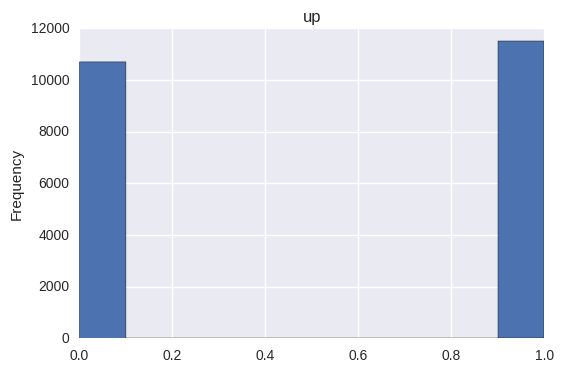

In [89]:
data_cl['U'].plot(kind='hist', grid=True, title='up')

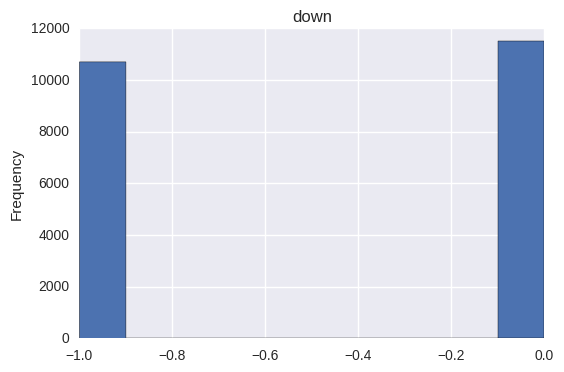

In [88]:
data_cl['D'].plot(kind='hist', grid=True, title='down')

##### around 25% up and 25% down

### saving classification model

In [78]:
X=data_cl[['askPrice','askSize','bidPrice','bidSize','spread','v','return','sigma']]
y1=data_cl.U
y2=data_cl.D

svm = SVC(kernel='linear')
lm = linear_model.LogisticRegression(C=1e4)

In [79]:
svm_model_up=svm.fit(X,y1)
lm_model_up=lm.fit(X,y1)
svm_model_dn=svm.fit(X,y2)
lm_model_dn =lm.fit(X,y2)

In [80]:
# save the model to disk
filename_svm_model_up = 'svm_model_up.sav'
filename_lm_model_up = 'lm_model_up.sav'
filename_svm_model_dn = 'svm_model_dn.sav'
filename_lm_model_dn = 'lm_model_dn.sav'
pickle.dump(svm_model_up, open(filename_svm_model_up, 'wb'))
pickle.dump(lm_model_up, open(filename_lm_model_up, 'wb'))
pickle.dump(svm_model_dn, open(filename_svm_model_dn, 'wb'))
pickle.dump(lm_model_dn, open(filename_lm_model_dn , 'wb'))

### loading classification for LSTM model saving

In [91]:
#### loading classification model from /Dropbox/DataScience/ML_20Sep
filename_svm_model_up = 'svm_model_up.sav'
filename_lm_model_up = 'lm_model_up.sav'
filename_svm_model_dn = 'svm_model_dn.sav'
filename_lm_model_dn = 'lm_model_dn.sav'
# load the model from disk
loaded_svm_up_model = pickle.load(open(filename_svm_model_up, 'rb'))
loaded_lm_up_model = pickle.load(open(filename_lm_model_up, 'rb'))
loaded_svm_dn_model = pickle.load(open(filename_svm_model_dn, 'rb'))
loaded_lm_dn_model = pickle.load(open(filename_lm_model_dn, 'rb'))

def classification_up_dn(data):
    X=data[['askPrice','askSize','bidPrice','bidSize','spread','v','return','sigma']]
    
    predict_svm_up=loaded_svm_up_model.predict(X)
    predict_lm_up=loaded_lm_up_model.predict(X)
    predict_svm_dn=loaded_svm_dn_model.predict(X)
    predict_lm_dn=loaded_lm_dn_model.predict(X)
    
    X['predict_svm_up']=predict_svm_up
    X['predict_lm_up']=predict_lm_up
    X['predict_svm_dn']=predict_svm_dn
    X['predict_lm_dn']=predict_lm_dn
    
    #X['predict_svm']=X.predict_svm_up+X.predict_svm_dn
    #X['predict_lm']=X.predict_lm_up+X.predict_lm_dn
    
    X['U']=np.where(np.logical_or(X.predict_svm_up==1,X.predict_lm_up==1),1,0)
    X['D']=np.where(np.logical_or(X.predict_svm_dn==-1,X.predict_lm_dn==-1),-1,0)  
       
    X['UD']=X.U+X.D
    return X

In [93]:
class_data=classification_up_dn(data_cl)

/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [99]:
data_cl.tail()

,askPrice,askSize,bidPrice,bidSize,mid,vwap,spread,v,return,sigma,U,D
2017-12-08 03:00:32.244925,263.839996,1.0,263.829987,576.0,263.834991,263.830017,-0.004974,0.019989,0.000038,0.003702,1,0
2017-12-08 03:00:34.284669,263.839996,1.0,263.829987,563.0,263.834991,263.830017,-0.004974,0.014984,0.000038,0.003723,1,0
2017-12-08 03:00:35.874931,263.839996,1.0,263.839996,563.0,263.839996,263.839996,0.000000,0.019989,0.000038,0.003723,1,0
2017-12-08 03:00:37.499670,263.839996,1.0,263.839996,17.0,263.839996,263.839966,-0.000031,0.014984,0.000000,0.003723,1,0
2017-12-08 03:00:39.356631,263.850006,1.0,263.839996,17.0,263.845001,263.840546,-0.004456,0.019989,0.000038,0.003652,1,0


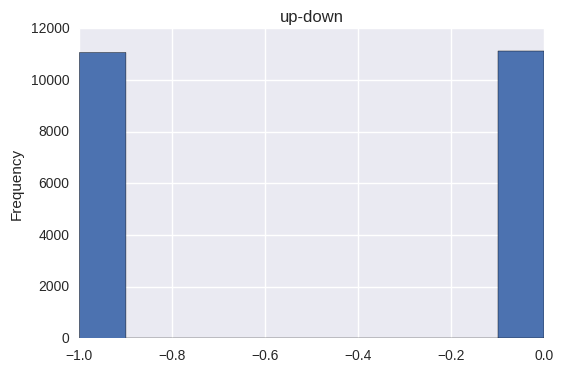

In [97]:
class_data['predict_svm_up'].plot(kind='hist', grid=True, title='up-down')

### there is problem in classification prediction, so direct use of UD

In [104]:
df_ml=pd.DataFrame()
data=get_csv_pd(filename)
data=preprocessing(data)
data=data.dropna()
df_arima=arima_processing(data)
df_ml['mid']=data.mid
df_ml['vwap']=data.vwap
ARIMA_(df_arima)
kalman_ma(data)
strat_lr(data)
df_ml=df_ml.dropna()
data_cl=data.tail(len(df_ml))
data_cl['U']=np.where(df_ml.mid>df_ml.km,1,0)
data_cl['D']=np.where(df_ml.mid<df_ml.km,-1,0)
data_cl=data_cl.dropna()
df_ml['UD']=data_cl.U+data_cl.D

/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/octo/anaconda2/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [105]:
df_ml.head()

,mid,vwap,arima,km,REG,SVR,UD
2017-12-07 20:13:37.388207,263.304993,263.307831,263.300703,263.297371,263.307217,263.377362,1
2017-12-07 20:13:37.859897,263.309998,263.309967,263.310746,263.298572,263.309350,263.378741,1
2017-12-07 20:13:38.330945,263.309998,263.309967,263.308663,263.299659,263.308788,263.378741,1
2017-12-07 20:13:38.802144,263.315002,263.319916,263.310354,263.301118,263.319292,263.385214,1
2017-12-07 20:13:39.252239,263.315002,263.319946,263.320369,263.302439,263.319322,263.385234,1


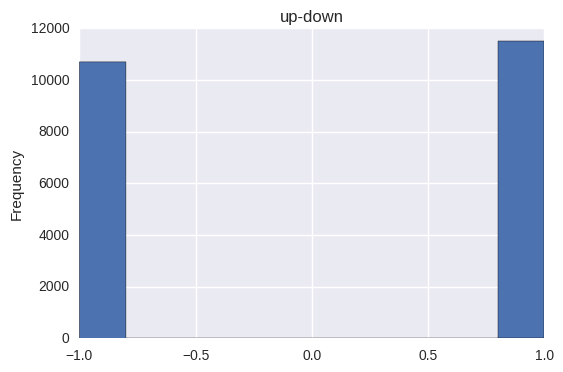

In [106]:
df_ml['UD'].plot(kind='hist', grid=True, title='up-down')

In [114]:
### LSTM

#df.loc[:, cols].prod(axis=1)
def lstm_processing(df):
    df=df.dropna()
    df_price=df[['mid','vwap','arima','km','REG','SVR']]
    #normalization
    dfn=np.log(df_price)
    #dfn['UD']=df.UD
    return dfn

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        b = dataset[i:(i+look_back), 1]
        c = dataset[i:(i+look_back), 2]
        d = dataset[i:(i+look_back), 3]
        e=  dataset[i:(i+look_back), 4]
        f = dataset[i:(i+look_back), 5]
        #g=  dataset[i:(i+look_back), 6]
        #dataX.append(np.c_[b,c,d,e,f,g])
        dataX.append(np.c_[b,c,d,e,f])
        #dataX.append(b)
        #dataX.append(c)
        #dataX.append(d)
        #dataX.append(e)
        #dataX.concatenate((a,bT,cT,dT,eT),axis=1)
        dataY.append(a)
    return np.array(dataX), np.array(dataY)

In [115]:
#normalization
df_lstm=lstm_processing(df_ml)
df_lstm=df_lstm.dropna()
dataset=df_lstm.values
dataset = dataset.astype('float32')
# reshape into X=t and Y=t+1
look_back = 3
X_,Y_ = create_dataset(dataset,look_back)
    
# reshape input to be [samples, time steps, features]
X_ = numpy.reshape(X_, (X_.shape[0],X_.shape[1],X_.shape[2]))

In [116]:
df_lstm.head()

,mid,vwap,arima,km,REG,SVR
2017-12-07 20:13:37.388207,5.573313,5.573324,5.573297,5.573284,5.573321,5.573588
2017-12-07 20:13:37.859897,5.573332,5.573332,5.573335,5.573289,5.573330,5.573593
2017-12-07 20:13:38.330945,5.573332,5.573332,5.573327,5.573293,5.573327,5.573593
2017-12-07 20:13:38.802144,5.573351,5.573370,5.573333,5.573298,5.573367,5.573618
2017-12-07 20:13:39.252239,5.573351,5.573370,5.573371,5.573303,5.573367,5.573618


In [126]:
'''
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back,5)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_,Y_, epochs, batch_size, verbose=2)
'''

"\n# create and fit the LSTM network\nmodel = Sequential()\nmodel.add(LSTM(4, input_shape=(look_back,5)))\nmodel.add(Dense(1))\nmodel.compile(loss='mean_squared_error', optimizer='adam')\nmodel.fit(X_,Y_, epochs, batch_size, verbose=2)\n"

In [127]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print ("Compilation Time : ", time.time() - start)
    return model

In [130]:
epochs=10
batch_size=50
layers=[5, 50, 100,3]
# create and fit the LSTM network
model = build_model(layers)

Compilation Time :  0.03835558891296387


In [131]:
model.fit(X_,Y_, epochs, batch_size, verbose=2)

Epoch 1/50
15s - loss: 0.2450
Epoch 2/50
14s - loss: 0.0746
Epoch 3/50
13s - loss: 0.0636
Epoch 4/50
13s - loss: 0.0559
Epoch 5/50
13s - loss: 0.0493
Epoch 6/50
16s - loss: 0.0431
Epoch 7/50
16s - loss: 0.0373
Epoch 8/50
15s - loss: 0.0316
Epoch 9/50
14s - loss: 0.0268
Epoch 10/50
16s - loss: 0.0225
Epoch 11/50
13s - loss: 0.0182
Epoch 12/50
16s - loss: 0.0148
Epoch 13/50
13s - loss: 0.0114
Epoch 14/50
17s - loss: 0.0089
Epoch 15/50
14s - loss: 0.0065
Epoch 16/50
17s - loss: 0.0046
Epoch 17/50
16s - loss: 0.0030
Epoch 18/50
15s - loss: 0.0018
Epoch 19/50
15s - loss: 9.0651e-04
Epoch 20/50
17s - loss: 3.5593e-04
Epoch 21/50
16s - loss: 8.4756e-05
Epoch 22/50
16s - loss: 9.5158e-06
Epoch 23/50
15s - loss: 7.7569e-07
Epoch 24/50
18s - loss: 7.5562e-07
Epoch 25/50
14s - loss: 7.5361e-07
Epoch 26/50
15s - loss: 7.4994e-07
Epoch 27/50
16s - loss: 7.4947e-07
Epoch 28/50
16s - loss: 7.4883e-07
Epoch 29/50
16s - loss: 7.4570e-07
Epoch 30/50
15s - loss: 7.4747e-07
Epoch 31/50
15s - loss: 7.5527e

In [132]:
model.save("12Dec.h5")

In [138]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(data, label='Prediction')
        plt.legend()
    plt.show()

In [134]:
Predict = model.predict(X_)
#testPredict = model.predict(testX)

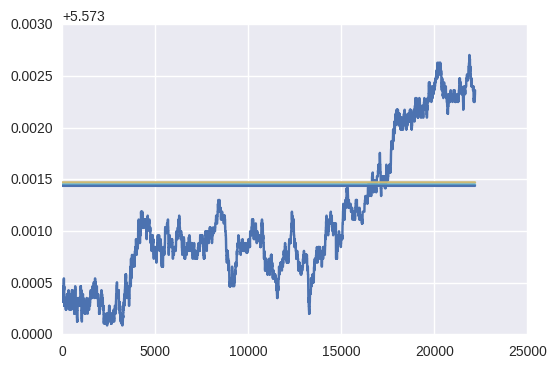

In [142]:
'''
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
#plt.plot(scaler.inverse_transform(dataset))
plt.plot(dataset[:,0])
#plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
'''

# shift train predictions for plotting
PredictPlot = numpy.empty_like(dataset)
PredictPlot[:, :] = numpy.nan
PredictPlot[look_back:len(Predict)+look_back,3:6] = Predict

plt.plot(dataset[:,0])
#plt.plot(trainPredictPlot)
plt.plot(PredictPlot)
plt.show()


In [ ]:
plot_results_multiple(Predict,Y_,10000)